# Oxford flower classification (Deep learning)


In [1]:
import torch                            # Core pytorch for tensor operator
import torch.nn as nn                   # Neural network module (layers, loss_function,..)
import torch.optim as optim             # optimization algorithms (SDG, RMSprop, Adam,...)
import torch.nn.functional as F         # Functional operations (activations, pooling,..)
import torch.utils.data as data         # Dataset handling and batching

import torchvision                                  # Computer vision utilities and pre-trained models
from torchvision import models
from torchvision import transforms                  # Image processing and augmentation
from torchvision import datasets                    # Image processing and augmentation
from torchvision.datasets import CIFAR100           # common CV datasets
from torchvision.models import resnet50             # Pre-trained model supported in PyTorch
from torchvision.models import ViT_B_16_Weights
from torchvision.models import vit_b_16
from torchinfo import summary

f"Torch version: {torch.__version__}", "^",\
f"Torchvision version: {torchvision.__version__}"

"""
A series of helper functions used throughout the course.
If a function gets defined once and could be used over and over, it'll go in here.
"""
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from pathlib import Path
import requests
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import time
import sys
import warnings
import random
from PIL import Image 
from datetime import datetime
warnings.filterwarnings("ignore")

# Get utils helper func
file_url = "https://raw.githubusercontent.com/lovecrushfamily/Oxford-flower-classification/refs/heads/main/utils.py"
file_name = "utils.py"
os.system(f"rm {file_name}")
os.system(f"wget -O {file_name} {file_url}")
import utils


## *Diagnostic Code*

In [2]:
import torch.version 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device name: {torch.cuda.get_device_name()}")
print(f"Using device: {device}")
print(f"Cuda version: {torch.version.cuda}")

Device name: Tesla P100-PCIE-16GB
Using device: cuda
Cuda version: 12.1


## *Inspect dataset*

In [3]:
!ls -l /kaggle/input/pytorch-challange-flower-dataset/dataset

total 0
drwxr-xr-x   2 nobody nogroup 0 Apr 16 11:57 test
drwxr-xr-x 104 nobody nogroup 0 Apr 16 11:58 train
drwxr-xr-x 104 nobody nogroup 0 Apr 16 11:58 valid


## *Set up directories*

In [4]:
train_dir = "/kaggle/input/pytorch-challange-flower-dataset/dataset/train"
test_dir = "/kaggle/input/pytorch-challange-flower-dataset/dataset/test"
valid_dir = "/kaggle/input/pytorch-challange-flower-dataset/dataset/valid"

train_dir, test_dir, valid_dir


('/kaggle/input/pytorch-challange-flower-dataset/dataset/train',
 '/kaggle/input/pytorch-challange-flower-dataset/dataset/test',
 '/kaggle/input/pytorch-challange-flower-dataset/dataset/valid')

## *Class names mapping*

In [5]:
# Class names from the "cat_to_name" file, now here
flower_names  = {
    "1":"pink primrose",
    "2":"hard-leaved pocket orchid",
    "3":"canterbury bells",
    "4":"sweet pea",
    "5":"english marigold",
    "6":"tiger lily",
    "7":"moon orchid",
    "8":"bird of paradise",
    "9":"monkshood",
    "10":"globe thistle",
    "11":"snapdragon",
    "12":"colt's foot",
    "13":"king protea",
    "14":"spear thistle",
    "15":"yellow iris",
    "16":"globe-flower",
    "17":"purple coneflower",
    "18":"peruvian lily",
    "19":"balloon flower",
    "20":"giant white arum lily",
    "21":"fire lily",
    "22":"pincushion flower",
    "23":"fritillary",
    "24":"red ginger",
    "25":"grape hyacinth",
    "26":"corn poppy",
    "27":"prince of wales feathers",
    "28":"stemless gentian",
    "29":"artichoke",
    "30":"sweet william",
    "31":"carnation",
    "32":"garden phlox",
    "33":"love in the mist",
    "34":"mexican aster",
    "35":"alpine sea holly",
    "36":"ruby-lipped cattleya",
    "37":"cape flower",
    "38":"great masterwort",
    "39":"siam tulip",
    "40":"lenten rose",
    "41":"barbeton daisy",
    "42":"daffodil",
    "43":"sword lily",
    "44":"poinsettia",
    "45":"bolero deep blue",
    "46":"wallflower",
    "47":"marigold",
    "48":"buttercup",
    "49":"oxeye daisy",
    "50":"common dandelion",
    "51":"petunia",
    "52":"wild pansy",
    "53":"primula",
    "54":"sunflower",
    "55":"pelargonium",
    "56":"bishop of llandaff",
    "57":"gaura",
    "58":"geranium",
    "59":"orange dahlia",
    "60":"pink-yellow dahlia",
    "61":"cautleya spicata",
    "62":"japanese anemone",
    "63":"black-eyed susan",
    "64":"silverbush",
    "65":"californian poppy",
    "66":"osteospermum",
    "67":"spring crocus",
    "68":"bearded iris",
    "69":"windflower",
    "70":"tree poppy",
    "71":"gazania",
    "72":"azalea",
    "73":"water lily",
    "74":"rose",
    "75":"thorn apple",
    "76":"morning glory",
    "77":"passion flower",
    "78":"lotus lotus",
    "79":"toad lily",
    "80":"anthurium",
    "81":"frangipani",
    "82":"clematis",
    "83":"hibiscus",
    "84":"columbine",
    "85":"desert-rose",
    "86":"tree mallow",
    "87":"magnolia",
    "88":"cyclamen",
    "89":"watercress",
    "90":"canna lily",
    "91":"hippeastrum",
    "92":"bee balm",
    "93":"ball moss",
    "94":"foxglove",
    "95":"bougainvillea",
    "96":"camellia",
    "97":"mallow",
    "98":"mexican petunia",
    "99":"bromelia",
    "100":"blanket flower",
    "101":"trumpet creeper",
    "102":"blackberry lily"}
    


## *Image transformation*

In [6]:
IMG_SIZE =224

simple_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

simple_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

## *Create Dataset and DataLoader*

In [7]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 16
print(f"Maximum number of cpu core available: {NUM_WORKERS}")

train_dataloader, valid_dataloader, classes = utils.create_dataloaders(train_dir=train_dir,
                                                                        valid_dir=valid_dir,
                                                                        transform=simple_transforms,
                                                                        batch_size=BATCH_SIZE,
                                                                        num_workers=NUM_WORKERS)         

train_dataloader, valid_dataloader, f"{classes}"

Maximum number of cpu core available: 4
Maximum number of cpu core available: 4


(<torch.utils.data.dataloader.DataLoader at 0x7821790ab670>,
 "['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']")

## *Image in batch*

In [8]:
image_batch, label_batch = next(iter(train_dataloader))
print(f"Image batch shape: {image_batch.shape} \nLabel batch shape: {label_batch.shape}")

Image batch shape: torch.Size([16, 3, 224, 224]) 
Label batch shape: torch.Size([16])


## Image in tensor

In [9]:
image, label = image_batch[1], label_batch[1]
image, '^', label

(tensor([[[0.1922, 0.1804, 0.1804,  ..., 0.0118, 0.0157, 0.0157],
          [0.1922, 0.1882, 0.1843,  ..., 0.0118, 0.0118, 0.0157],
          [0.1961, 0.1843, 0.1686,  ..., 0.0078, 0.0078, 0.0157],
          ...,
          [0.1490, 0.1569, 0.1765,  ..., 0.2196, 0.1961, 0.1882],
          [0.1451, 0.1529, 0.1686,  ..., 0.2078, 0.2118, 0.2196],
          [0.1451, 0.1529, 0.1686,  ..., 0.2118, 0.2235, 0.2471]],
 
         [[0.2784, 0.2588, 0.2549,  ..., 0.0078, 0.0118, 0.0118],
          [0.2784, 0.2706, 0.2706,  ..., 0.0078, 0.0078, 0.0118],
          [0.2745, 0.2667, 0.2627,  ..., 0.0039, 0.0039, 0.0118],
          ...,
          [0.1843, 0.1961, 0.2235,  ..., 0.3961, 0.3765, 0.3725],
          [0.1804, 0.1922, 0.2118,  ..., 0.3843, 0.4039, 0.4157],
          [0.1804, 0.1922, 0.2078,  ..., 0.3843, 0.4235, 0.4471]],
 
         [[0.6235, 0.7255, 0.7333,  ..., 0.0275, 0.0314, 0.0314],
          [0.5804, 0.6510, 0.6784,  ..., 0.0275, 0.0275, 0.0314],
          [0.5294, 0.5529, 0.5843,  ...,

## Show off single image

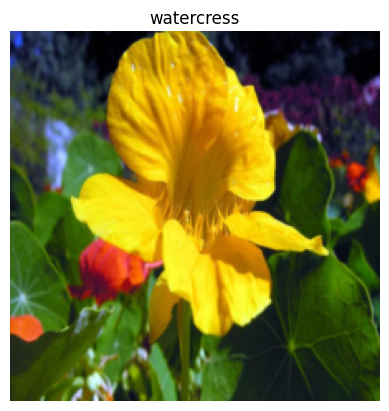

In [10]:
plt.imshow(image.permute(1, 2, 0))
plt.title(flower_names[classes[label]])
plt.axis(False)
plt.show()

## *Show off batch of images*

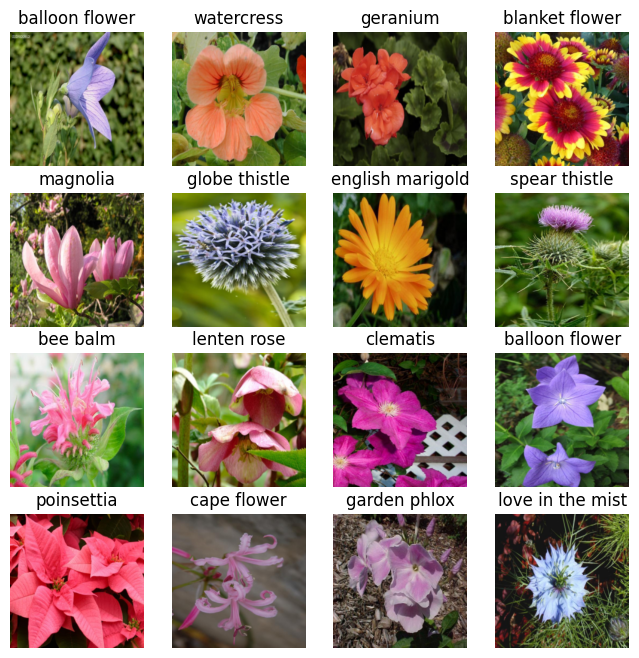

In [11]:
def show_batch(dataloader, batch_size:int):
    """Displays a batch of images from the dataloader in a grid format."""
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(int(np.sqrt(batch_size)), int(np.sqrt(batch_size)), figsize=(8, 8))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.permute(1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
        ax.set_title(flower_names[classes[label.item()]])  # Convert tensor label to integer
        ax.axis("off")  # Hide axes
    
    plt.show()

show_batch(train_dataloader, 
           batch_size=BATCH_SIZE)

# Simple ANN

In [12]:
class Oxford_Modelv0_SimpleANN(nn.Module):
    def __init__(self, input_shape: int,
                hidden_units: int,
                hidden_layers: int,
                output_shape: int,
                activations: nn.Module):
        super().__init__()

        layers = [nn.Flatten()]                                                               # Start with Flatten Layer
        
        layers.append(nn.Linear(in_features=input_shape, out_features= hidden_units))        # Adding input layers
        layers.append(activations)

        for _ in range(hidden_layers - 1):                                                    # Adding dynamic hidden layer
            layers.append(nn.Linear(hidden_units, hidden_units))
            layers.append(activations)

        layers.append(nn.Linear(hidden_units, output_shape))                                  # Adding output layers


        self.layers = nn.Sequential(*layers)                                                  # Unpack list of layers into Sequential

    def forward(self, x):
        return self.layers(x)


modelv0 = Oxford_Modelv0_SimpleANN(input_shape = 150528, 
                               hidden_units = 50,
                               hidden_layers = 2,
                               output_shape= len(classes),
                               activations=nn.ReLU()).to(device)
modelv0

Oxford_Modelv0_SimpleANN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=50, bias=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): ReLU()
    (5): Linear(in_features=50, out_features=102, bias=True)
  )
)

In [13]:
summary(model=modelv0,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape               Output Shape              Param #                   Trainable
Oxford_Modelv0_SimpleANN (Oxford_Modelv0_SimpleANN)     [1, 3, 224, 224]          [1, 102]                  --                        True
├─Sequential (layers)                                   [1, 3, 224, 224]          [1, 102]                  --                        True
│    └─Flatten (0)                                      [1, 3, 224, 224]          [1, 150528]               --                        --
│    └─Linear (1)                                       [1, 150528]               [1, 50]                   7,526,450                 True
│    └─ReLU (4)                                         [1, 50]                   [1, 50]                   --                        --
│    └─Linear (3)                                       [1, 50]                   [1, 50]                   2,550                     True
│    └─ReLU (4)           

Epoch 1/5 [==============================] 100% [00:00:21<00:00:00] loss: 6.3702 - acc: 0.0312 - lr: 0.0100
Epoch 2/5 [==============================] 100% [00:00:39<00:00:00] loss: 4.5223 - acc: 0.0317 - lr: 0.0100
Epoch 3/5 [==============================] 100% [00:00:58<00:00:00] loss: 4.5161 - acc: 0.0303 - lr: 0.0100
Epoch 4/5 [==============================] 100% [00:01:16<00:00:00] loss: 4.5139 - acc: 0.0305 - lr: 0.0100
Epoch 5/5 [==============================] 100% [00:01:34<00:00:00] loss: 4.5139 - acc: 0.0303 - lr: 0.0100


[INFO] Saving model to: saved_models/Oxford_Modelv0_SimpleANN_16_04_2025_13_40_07_Tesla P100-PCIE-16GB.pth


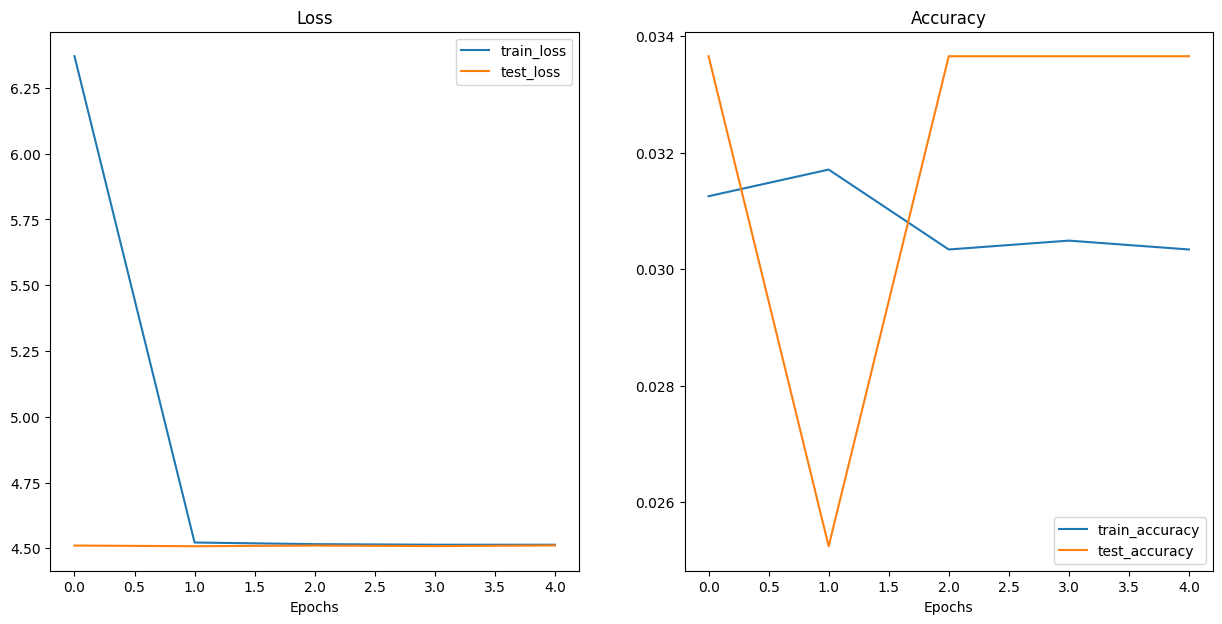

In [14]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=modelv0.parameters(), lr = 0.01)

# Callback


# Train model
modelv0_result = utils.train_model(model=modelv0,
                             train_dataloader=train_dataloader,
                             test_dataloader=valid_dataloader,
                             optimizer=optimizer,
                             loss_fn=criterion,
                             epochs=5,
                             device=device)

# Save the model
print('\n')
utils.save_model(model=modelv0)

# Evaluate learning curve
utils.plot_loss_curves(modelv0_result)


# Simple CNN

In [15]:
class Oxford_Modelv1_SimpleCNN(nn.Module):
    def __init__(self, num_classes=102):  # 102 flower categories
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # (224x224x3) -> (224x224x32)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)  # Downsample (112x112x32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (112x112x32) -> (112x112x64)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # (56x56x128)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Flatten layer
        self.fc2 = nn.Linear(512, num_classes)   # Output 102 classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  
        x = torch.flatten(x, 1)  # Flatten for FC layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation here (CrossEntropyLoss applies softmax)
        return x


modelv1 = Oxford_Modelv1_SimpleCNN()

summary(model=modelv1,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape               Output Shape              Param #                   Trainable
Oxford_Modelv1_SimpleCNN (Oxford_Modelv1_SimpleCNN)     [1, 3, 224, 224]          [1, 102]                  --                        True
├─Conv2d (conv1)                                        [1, 3, 224, 224]          [1, 32, 224, 224]         896                       True
├─BatchNorm2d (bn1)                                     [1, 32, 224, 224]         [1, 32, 224, 224]         64                        True
├─MaxPool2d (pool)                                      [1, 32, 224, 224]         [1, 32, 112, 112]         --                        --
├─Conv2d (conv2)                                        [1, 32, 112, 112]         [1, 64, 112, 112]         18,496                    True
├─BatchNorm2d (bn2)                                     [1, 64, 112, 112]         [1, 64, 112, 112]         128                       True
├─MaxPool2d (pool)      

Epoch 1/5 [==============================] 100% [00:00:17<00:00:00] loss: 4.6342 - acc: 0.0102 - lr: 0.0100
Epoch 2/5 [==============================] 100% [00:00:36<00:00:00] loss: 4.6340 - acc: 0.0098 - lr: 0.0100
Epoch 3/5 [==============================] 100% [00:00:56<00:00:00] loss: 4.6346 - acc: 0.0095 - lr: 0.0100
Epoch 4/5 [==============================] 100% [00:01:16<00:00:00] loss: 4.6348 - acc: 0.0093 - lr: 0.0100
Epoch 5/5 [==============================] 100% [00:01:36<00:00:00] loss: 4.6341 - acc: 0.0093 - lr: 0.0100


[INFO] Saving model to: saved_models/Oxford_Modelv1_SimpleCNN_16_04_2025_13_41_47_Tesla P100-PCIE-16GB.pth


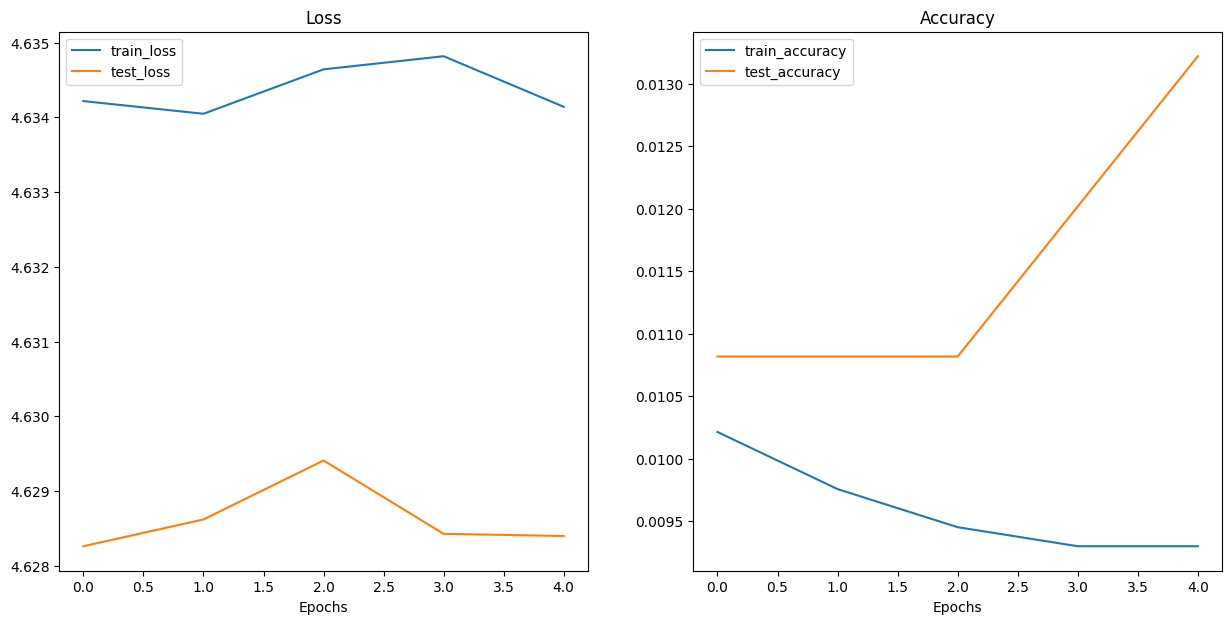

In [16]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=modelv0.parameters(), lr = 0.01)

# Callback


# Train model
modelv1_result = utils.train_model(model=modelv1,
                             train_dataloader=train_dataloader,
                             test_dataloader=valid_dataloader,
                             optimizer=optimizer,
                             loss_fn=criterion,
                             epochs=5,
                             device=device)

# Save the model
print('\n')
utils.save_model(model=modelv1)

# Evaluate learning curve
utils.plot_loss_curves(modelv1_result)


# ResNet


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = self.downsample(x) if self.downsample else x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + identity)

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample

    def forward(self, x):
        identity = self.downsample(x) if self.downsample else x
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        return F.relu(out + identity)

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = nn.Sequential(
            nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels * block.expansion),
        ) if stride != 1 or self.in_channels != out_channels * block.expansion else None
        
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        layers.extend(block(self.in_channels, out_channels) for _ in range(1, blocks))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        return self.fc(torch.flatten(x, 1))

# ResNet variants
def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def resnet34(num_classes=1000):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

def resnet50(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

def resnet101(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)

def resnet152(num_classes=1000):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)

# Example usage
model = resnet18(num_classes=102)  # For Oxford Flowers-102 dataset


In [18]:
# class ResBlock(nn..Module):
#     expansion = 1
#     def __init__(self, in_channels,  out_channels, i_downsample=None, stride=1):
#         super(ResBlock, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.batch_norm1 = nn.BatchNorm2d(out_channels)
#         self.conv2 = nnn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.batch_norm2 = nn.BatchNorm2d(out_channels)

#         self.i_downsample = i_downsample
#         self.stride = stride
#         self.relu = nn.ReLU()


#     def forward(self, x):
#         identity

# MobileNetv1

In [23]:
class Oxford_Modelv4_MobileNetV1(nn.Module):
    def __init__(self, ch_in, n_classes):
        super().__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
                )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                # pw
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            conv_bn(ch_in, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x


modelv4 = Oxford_Modelv4_MobileNetV1(ch_in=3, n_classes=1000)
summary(model=modelv4,
        input_size=(1, 3, 224, 224),  # Batch size of 1, 3 channels, 224x224 image
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
Oxford_Modelv4_MobileNetV1 (Oxford_Modelv4_MobileNetV1)      [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential (model)                                         [1, 3, 224, 224]          [1, 1024, 1, 1]           --                        True
│    └─Sequential (0)                                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─ReLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                

Epoch 1/5 [==============================] 100% [00:00:17<00:00:00] loss: 6.9723 - acc: 0.0003 - lr: 0.0100
Epoch 2/5 [==============================] 100% [00:00:38<00:00:00] loss: 6.9736 - acc: 0.0002 - lr: 0.0100
Epoch 3/5 [==============================] 100% [00:00:58<00:00:00] loss: 6.9723 - acc: 0.0000 - lr: 0.0100
Epoch 4/5 [==============================] 100% [00:01:18<00:00:00] loss: 6.9725 - acc: 0.0000 - lr: 0.0100
Epoch 5/5 [==============================] 100% [00:01:39<00:00:00] loss: 6.9718 - acc: 0.0003 - lr: 0.0100


[INFO] Saving model to: saved_models/Oxford_Modelv4_MobileNetV1_16_04_2025_13_45_10_Tesla P100-PCIE-16GB.pth


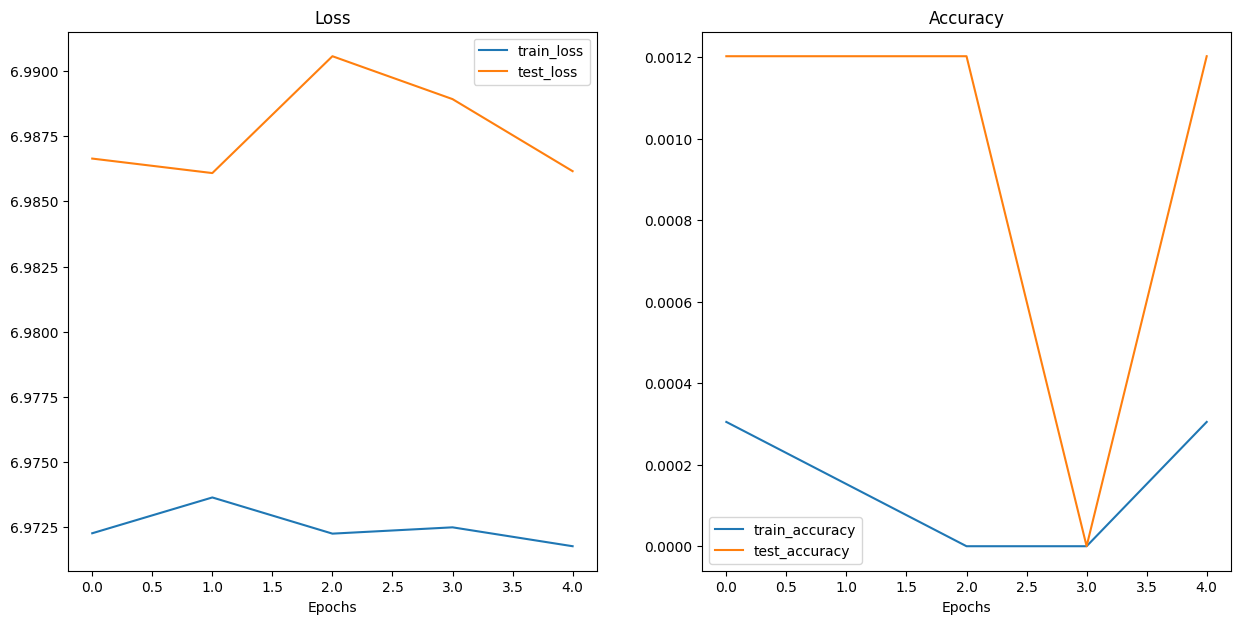

In [24]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=modelv0.parameters(), lr = 0.01)

# Callback


# Train model
modelv4_result = utils.train_model(model=modelv4,
                             train_dataloader=train_dataloader,
                             test_dataloader=valid_dataloader,
                             optimizer=optimizer,
                             loss_fn=criterion,
                             epochs=5,
                             device=device)

# Save the model
print('\n')
utils.save_model(model=modelv4)

# Evaluate learning curve
utils.plot_loss_curves(modelv4_result)


## MobileNetv3


In [26]:
import torch
import torch.nn as nn
import math

class SEModule(nn.Module):
    """Squeeze-and-Excitation module"""
    def __init__(self, channels, reduction=4):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

class InvertedResidual(nn.Module):
    """Inverted Residual Block with optional SE and expansion"""
    def __init__(self, in_channels, out_channels, expansion, stride, use_se, kernel_size=3):
        super(InvertedResidual, self).__init__()
        hidden_dim = in_channels * expansion
        self.use_residual = stride == 1 and in_channels == out_channels

        layers = []
        if expansion != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, 1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.Hardswish(inplace=True))

        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, kernel_size//2, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.Hardswish(inplace=True)
        ])

        if use_se:
            layers.append(SEModule(hidden_dim))

        layers.extend([
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_residual:
            return x + self.conv(x)
        return self.conv(x)

class MobileNetV3(nn.Module):
    def __init__(self, num_classes=1000, width_mult=1.0):
        super(MobileNetV3, self).__init__()
        # MobileNetV3-Small configuration
        cfg = [
            # expansion, out_channels, kernel_size, stride, use_se
            [1, 16, 3, 2, True],   # Block 1
            [4, 24, 3, 2, False],  # Block 2
            [3, 24, 3, 1, False],  # Block 3
            [4, 40, 5, 2, True],   # Block 4
            [6, 40, 5, 1, True],   # Block 5
            [6, 40, 5, 1, True],   # Block 6
            [6, 48, 3, 1, True],   # Block 7
            [6, 48, 3, 1, True],   # Block 8
            [6, 96, 3, 2, True],   # Block 9
            [6, 96, 3, 1, True],   # Block 10
            [6, 96, 3, 1, True],   # Block 11
        ]

        input_channel = int(16 * width_mult)
        self.features = nn.Sequential(
            nn.Conv2d(3, input_channel, 3, 2, 1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.Hardswish(inplace=True)
        )

        # Build inverted residual blocks
        for expansion, out_channels, kernel_size, stride, use_se in cfg:
            out_channels = int(out_channels * width_mult)
            self.features.append(
                InvertedResidual(input_channel, out_channels, expansion, stride, use_se, kernel_size)
            )
            input_channel = out_channels

        # Last several layers
        last_channel = int(576 * width_mult)
        self.features.append(
            nn.Sequential(
                nn.Conv2d(input_channel, last_channel, 1, bias=False),
                nn.BatchNorm2d(last_channel),
                nn.Hardswish(inplace=True),
                nn.AdaptiveAvgPool2d(1)
            )
        )

        self.classifier = nn.Sequential(
            nn.Linear(last_channel, 1024),
            nn.Hardswish(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

def mobilenet_v3_small(num_classes=1000, width_mult=1.0):
    return MobileNetV3(num_classes, width_mult)

# Fix input_shape to 3 (RGB channels)
torch.manual_seed(16)
modelv5 = Oxford_Modelv5_TinyVGG(input_shape=3, 
                                 hidden_units=10, 
                                 output_shape=102).to(device)

# Fix input_size to a tuple (batch_size, channels, height, width)
summary(model=modelv5,
        input_size=(1, 3, 224, 224),  # Batch size of 1, 3 channels, 224x224 image
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
Oxford_Modelv5_TinyVGG (Oxford_Modelv5_TinyVGG)    [1, 3, 224, 224]          [1, 102]                  --                        True
├─Sequential (conv_block_1)                        [1, 3, 224, 224]          [1, 10, 112, 112]         --                        True
│    └─Conv2d (0)                                  [1, 3, 224, 224]          [1, 10, 224, 224]         280                       True
│    └─ReLU (1)                                    [1, 10, 224, 224]         [1, 10, 224, 224]         --                        --
│    └─Conv2d (2)                                  [1, 10, 224, 224]         [1, 10, 224, 224]         910                       True
│    └─ReLU (3)                                    [1, 10, 224, 224]         [1, 10, 224, 224]         --                        --
│    └─MaxPool2d (4)                               [1, 10, 22

# TinyVGG

In [25]:
class Oxford_Modelv5_TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces size to 112x112
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces size to 56x56
        )

        # Compute final feature map size dynamically instead of hardcoding 16x16
        self.flatten_shape = hidden_units * (224 // 4) * (224 // 4)  # 56x56 if two max pools are applied

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.flatten_shape, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)


# Fix input_shape to 3 (RGB channels)
torch.manual_seed(16)
modelv5 = Oxford_Modelv5_TinyVGG(input_shape=3, 
                                 hidden_units=10, 
                                 output_shape=102).to(device)

# Fix input_size to a tuple (batch_size, channels, height, width)
summary(model=modelv5,
        input_size=(1, 3, 224, 224),  # Batch size of 1, 3 channels, 224x224 image
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"])


Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
Oxford_Modelv5_TinyVGG (Oxford_Modelv5_TinyVGG)    [1, 3, 224, 224]          [1, 102]                  --                        True
├─Sequential (conv_block_1)                        [1, 3, 224, 224]          [1, 10, 112, 112]         --                        True
│    └─Conv2d (0)                                  [1, 3, 224, 224]          [1, 10, 224, 224]         280                       True
│    └─ReLU (1)                                    [1, 10, 224, 224]         [1, 10, 224, 224]         --                        --
│    └─Conv2d (2)                                  [1, 10, 224, 224]         [1, 10, 224, 224]         910                       True
│    └─ReLU (3)                                    [1, 10, 224, 224]         [1, 10, 224, 224]         --                        --
│    └─MaxPool2d (4)                               [1, 10, 22

In [ ]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=modelv0.parameters(), lr = 0.01)

# Callback


# Train model
modelv5_result = utils.train_model(model=modelv5,
                             train_dataloader=train_dataloader,
                             test_dataloader=valid_dataloader,
                             optimizer=optimizer,
                             loss_fn=criterion,
                             epochs=5,
                             device=device)

# Save the model
print('\n')
utils.save_model(model=modelv5)

# Evaluate learning curve
utils.plot_loss_curves(modelv5_result)


# TinyVGG (customed)

In [ ]:
modelv5_customed = Oxford_Modelv5_TinyVGG(input_shape=3,
                                hidden_units=10,
                                output_shape=102)

modelv5_customed.classifier = Oxford_Modelv0_SimpleANN(input_shape = 31360, 
                               hidden_units = 10,
                               hidden_layers = 2,
                               output_shape= len(classes),
                               activations=nn.ReLU())

modelv5_customed


summary(model=modelv5_customed,
        input_size=(1, 3, 224, 224),  # Batch size of 1, 3 channels, 224x224 image
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"])


In [ ]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=modelv0.parameters(), lr = 0.01)

# Callback


# Train model
modelv5_customed_result = utils.train_model(model=modelv5_customed,
                             train_dataloader=train_dataloader,
                             test_dataloader=valid_dataloader,
                             optimizer=optimizer,
                             loss_fn=criterion,
                             epochs=5,
                             device=device)

# Save the model
print('\n')
utils.save_model(model=modelv5_customed)

# Evaluate learning curve
utils.plot_loss_curves(modelv5_customed_result)


# ViT

## *Patch embedding*

In [ ]:
class PatchEmbedding(nn.Module):
    """Turn a 2D input into a 1D sequence learnable embedding vector"""
    def __init__(self, 
                in_channels:int=3,
                patch_size:int=16,
                embedding_dim:int=768):
        super().__init__()

        self.in_channels = in_channels
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim

        self.patcher = nn.Conv2d(in_channels=self.in_channels,
                                out_channels=self.embedding_dim,
                                kernel_size=self.patch_size,
                                padding=0)
        self.flatten = nn.Flatten(start_dim=2,
                                    end_dim=3)

    def forward(self, x):
        """Create assertion  check that inputs are correct shape"""
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input Image size must be divisiblle by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)
        

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

patchify
        

In [ ]:
random_input_image = (1, 3, 224, 224)

summary(PatchEmbedding(),
       input_size=random_input_image,
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=25,
       row_settings=["var_names"]) 

## *Class tokem embedding*

## *Multi-Head Attention (MSA)*

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    """
        Create mutil-head self-attention block ("MSA block" for short)
    """
    def __init__(self,
                embedding_dim:int=768,
                num_heads:int=12,
                attn_dropout:float=0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mutilhead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=attn_dropout,
                                                   batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.mutilhead_attn(query=x,
                                           key=x,
                                           value=x,
                                           need_weights=False)

        return attn_output

multihead_self_attention_block = MultiHeadSelfAttention(embedding_dim=768,
                                                       num_heads=12)

multihead_self_attention_block

## *Multilayer Perceptron*

In [ ]:
class MLP(nn.Module):

    def __init__(self,
                embedding_dim:int=768,
                mlp_size:int=3072,
                dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                     out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                     out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        return self.mlp(x)


mlp_block = MLP(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

mlp_block
    

## *Transformer Encoder*

In [ ]:
class TransformerEncoder(nn.Module):
    """
        Create transformer encoder block
    """
    def __init__(self,
                embedding_dim:int=768,
                num_heads:int=12,
                mlp_size:int=3072,
                mlp_dropout:float=0.1,
                attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiHeadSelfAttention(embedding_dim=embedding_dim,
                                               num_heads=num_heads,
                                               attn_dropout=attn_dropout)

        self.mlp_block = MLP(embedding_dim=embedding_dim,
                            mlp_size=mlp_size,
                            dropout=mlp_dropout)

    def forward(self, x):

        x = self.msa_block(x) + x                    # create residual conection for MSA block (add input to the output)
        x = self.mlp_block(x) + x                    # create residual conection for MLP block (add input to the output)

        return x

transformer_encoder_block = TransformerEncoder()
transformer_encoder_block

## *Vision transformer*

In [ ]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    
    def __init__(self,                                         # 2. Initialize the class with hyperparameters from Table 1 and Table 3
                 img_size:int=224,                             # Training resolution from Table 3 in ViT paper
                 in_channels:int=3,                            # Number of channels in input image
                 patch_size:int=16,                            # Patch size
                 num_transformer_layers:int=12,                # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768,                        # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072,                            # MLP size from Table 1 for ViT-Base
                 num_heads:int=12,                             # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0,                         # Dropout for attention projection
                 mlp_dropout:float=0.1,                        # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1,                  # Dropout for patch and position embeddings
                 num_classes:int=1000):                        # Default for ImageNet but can customize this
        
        super().__init__()                                     # don't forget the super().__init__()!
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."     # 3. Make the image size is divisible by the patch size
        self.num_patches = (img_size * img_size) // patch_size**2                                                                               # 4. Calculate number of patches (height * width/patch^2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),                                                              # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
                                            requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),                                          # 6. Create learnable position embedding
                                               requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)                                                                                # 7. Create embedding dropout value
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,                                                                          # 8. Create patch embedding layer
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(embedding_dim=embedding_dim,                                         # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
                                                                            num_heads=num_heads,                                                # Note: The "*" means "all"
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(                                                                                                        # 10. Create classifier head
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):                                                       # 11. Create a forward() method
        batch_size = x.shape[0]                                                 # 12. Get batch size
                                                                                # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1)           # "-1" means to infer the dimension (try this line on its own)
        
        x = self.patch_embedding(x)                                             # 14. Create patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)                                  # 15. Concat class embedding and patch embedding (equation 1)
        x = self.position_embedding + x                                         # 16. Add position embedding to patch embedding (equation 1)    
        x = self.embedding_dropout(x)                                           # 17. Run embedding dropout (Appendix B.1)
        x = self.transformer_encoder(x)                                         # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.classifier(x[:, 0])                                            # 19. Put 0 index logit through classifier (equation 4)

        return x

vit = ViT()
vit

In [ ]:

summary(model=vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"]
)


 # Pre-trained ViT

In [ ]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = models.ViT_B_16_Weights.DEFAULT 
pretrained_vit = models.vit_b_16(weights=pretrained_vit_weights).to(device)



## *Freeze the base Paramaters*

In [ ]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


## *Change the classified head*

In [ ]:
# Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(classes)).to(device)
pretrained_vit

## *Summarize model*

In [ ]:
summary(model=pretrained_vit,
        input_size=(NUM_WORKERS, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"]
)

## *Pre-trained ViT transform*

In [ ]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

## *Setup DataLoader*

In [ ]:
train_dataloader_pretrained, \
    test_dataloader_pretrained, \
        class_names = create_dataloaders(train_dir=train_dir,
                                        valid_dir=valid_dir,
                                        transform=pretrained_vit_transforms,
                                        batch_size=NUM_WORKERS) 

train_dataloader_pretrained, \
    test_dataloader_pretrained, \
        f"{class_names}"

## *Training Pre-trained ViT*

In [ ]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_results = train_model(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=2,
                                      device=device)

In [ ]:
plot_loss_curves(pretrained_vit_results)



##  *Save the model*


In [ ]:
# Save the model
utils.save_model(model=pretrained_vit)

## random_input_image = (1, 3, 224, 224)

summary(PatchEmbedding(),
       input_size=random_input_image,
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=25,
       row_settings=["var_names"]) Inference